In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import librosa
import pywt

# Load data and process

In [9]:
# Load the data from the files
training_data = np.load('/kaggle/input/training/training_data.npy')
valid_periods = np.load('/kaggle/input/training/valid_periods.npy')
categories = np.load('/kaggle/input/training/categories.npy')

training_data.shape, valid_periods.shape, categories.shape

((48000, 2776), (48000, 2), (48000,))

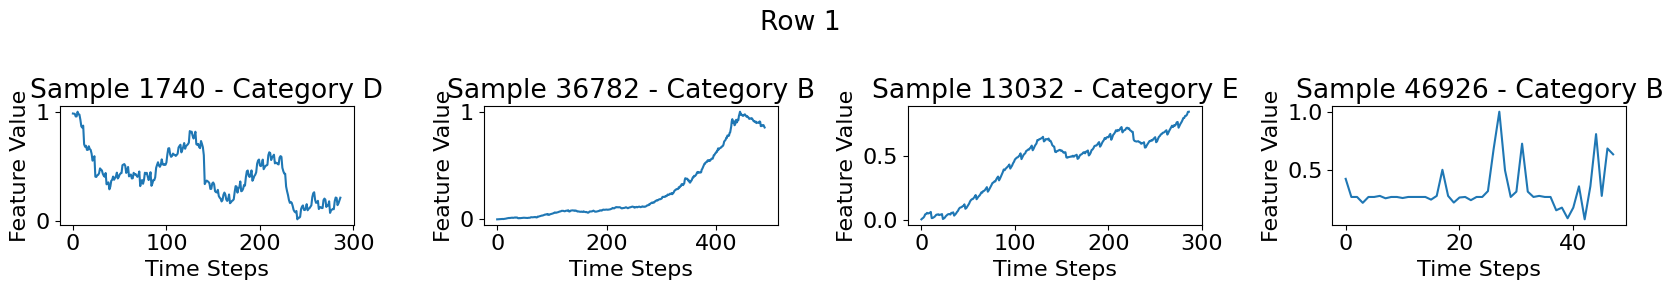

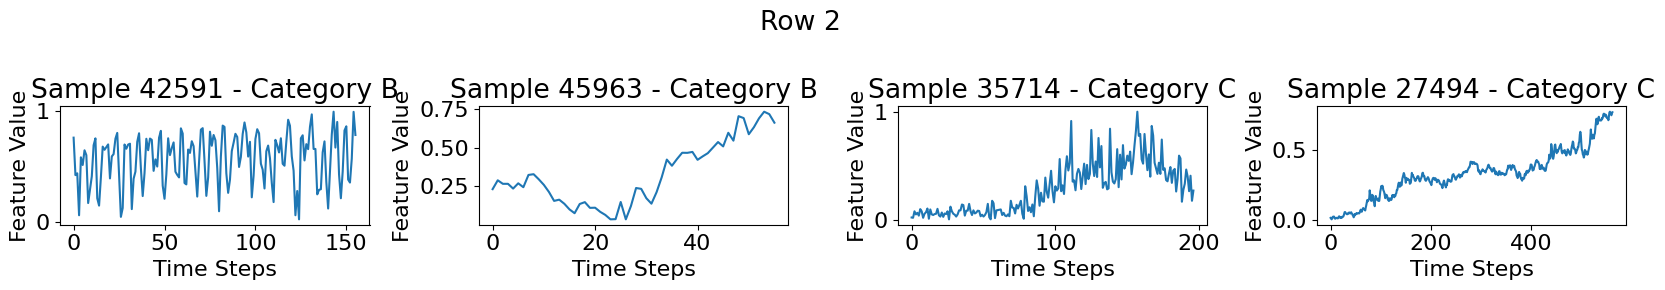

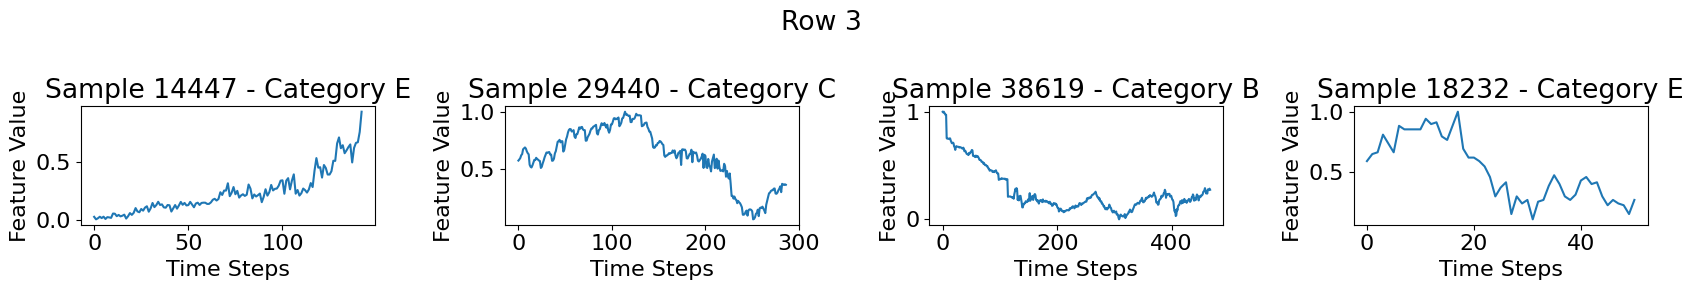

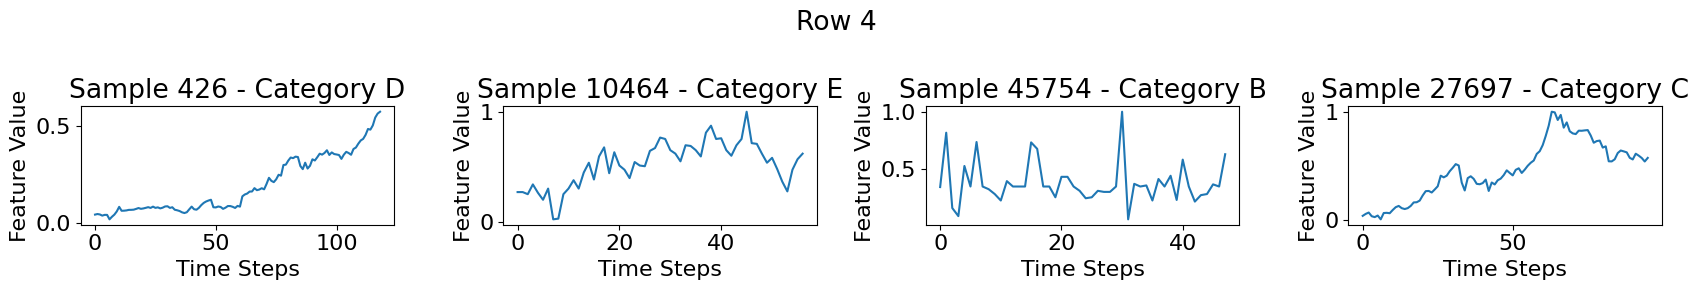

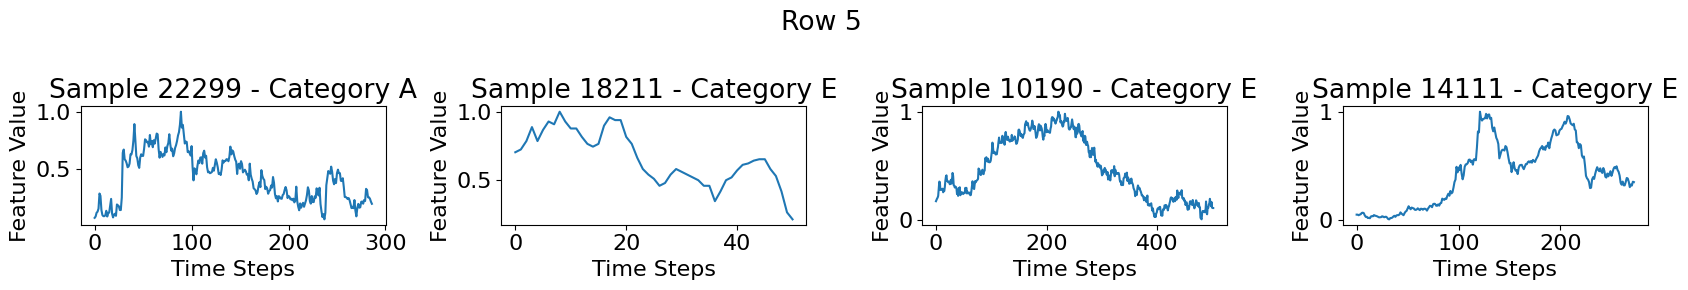

In [10]:
# Plot N rows of samples,4 samples per row

N = 5

# indices = range(100) # First 100 samples
indices = [random.randint(0, len(training_data) - 1) for _ in range(N * 4)]

num_samples_per_row = 4
num_rows = len(indices) // num_samples_per_row

for row in range(num_rows):
    plt.figure(figsize=(17, 3))
    plt.suptitle(f'Row {row + 1}')

    for col in range(num_samples_per_row):
        idx = row * num_samples_per_row + col

        if idx >= len(indices):
            break

        sample_idx = indices[idx]

        # Find the non-zero indices in the time series
        non_zero_indices = np.nonzero(training_data[sample_idx])[0]

        # Trim the time series to remove padding
        trimmed_series = training_data[sample_idx, non_zero_indices]

        plt.subplot(1, num_samples_per_row, col + 1)
        plt.plot(trimmed_series)
        plt.title(f'Sample {sample_idx + 1} - Category {categories[sample_idx]}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()


In [52]:
reduced_data = []

for idx in range(len(training_data)):
    if valid_periods[idx][1] - valid_periods[idx][0] <= 200:
        continue
               
    selected_indices = random.sample(range(valid_periods[idx][0], valid_periods[idx][1] - 1), 200)
    selected_indices.sort()
    selected_200_points = training_data[idx, selected_indices]
    
    reduced_data.append(selected_200_points)
    
reduced_data = np.array(reduced_data)

len(reduced_data), len(training_data)

(22611, 48000)

11407 [2512 2776]
22513 [2488 2776]


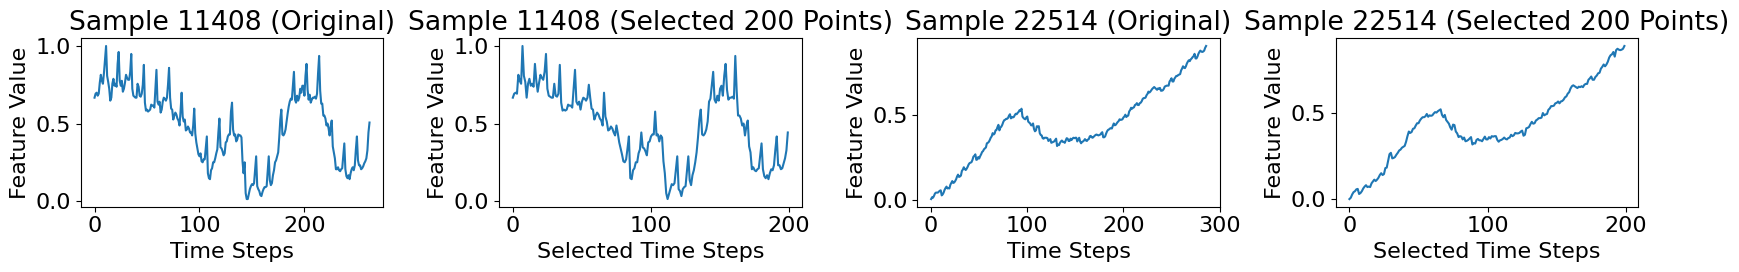

5019 [2494 2776]
1503 [2488 2776]


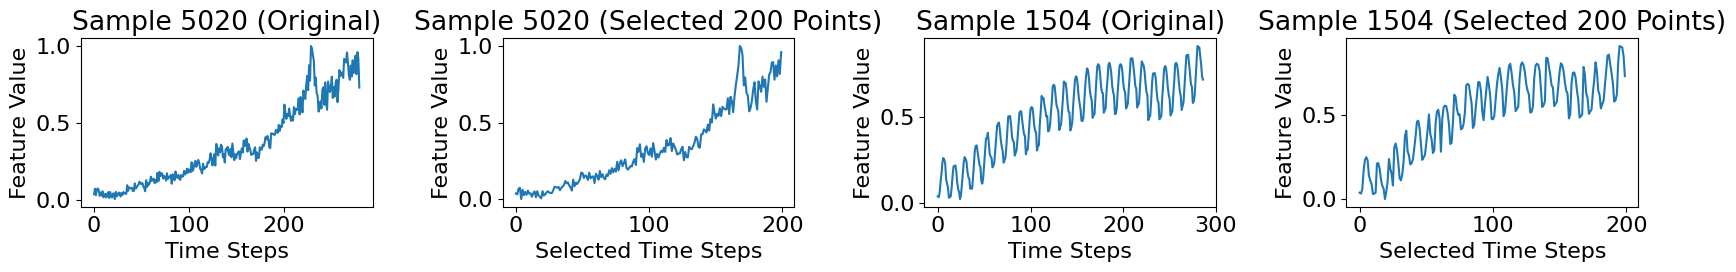

1516 [2488 2776]
22549 [2488 2776]


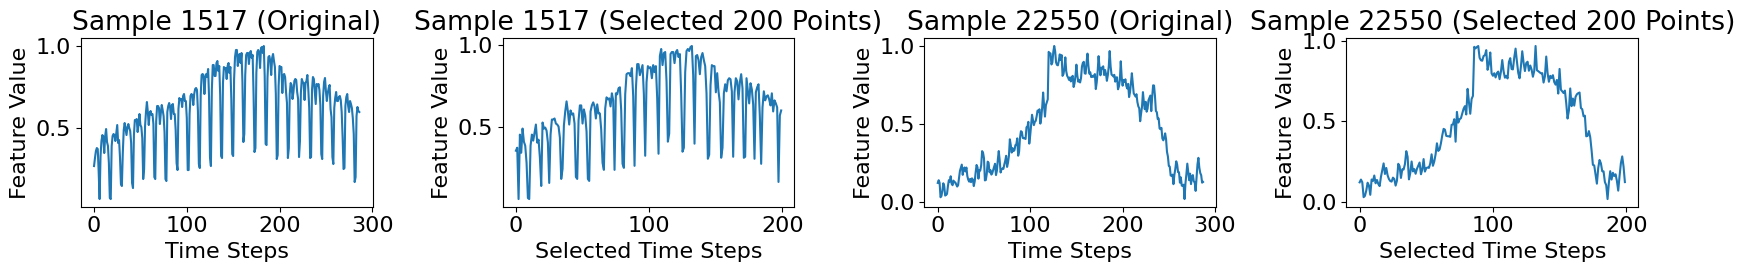

4939 [2440 2776]
14527 [2395 2776]


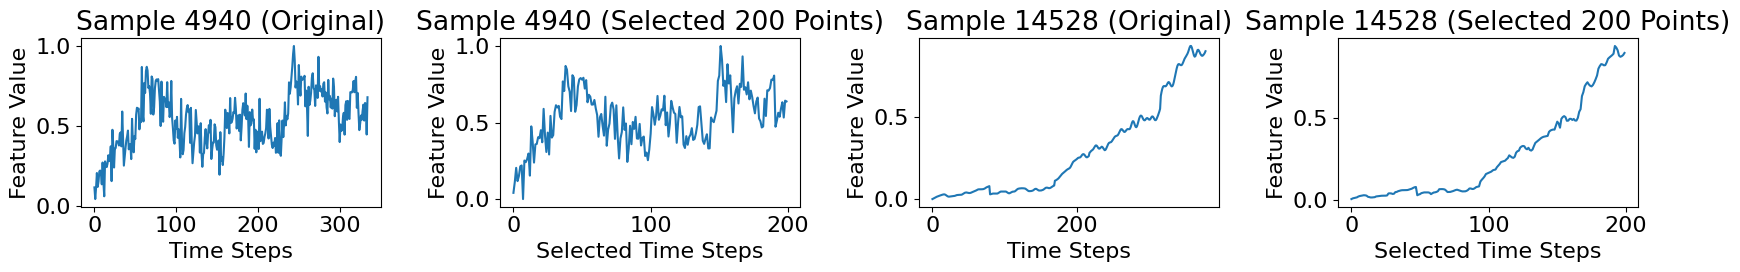

6494 [2552 2776]
10960 [2512 2776]


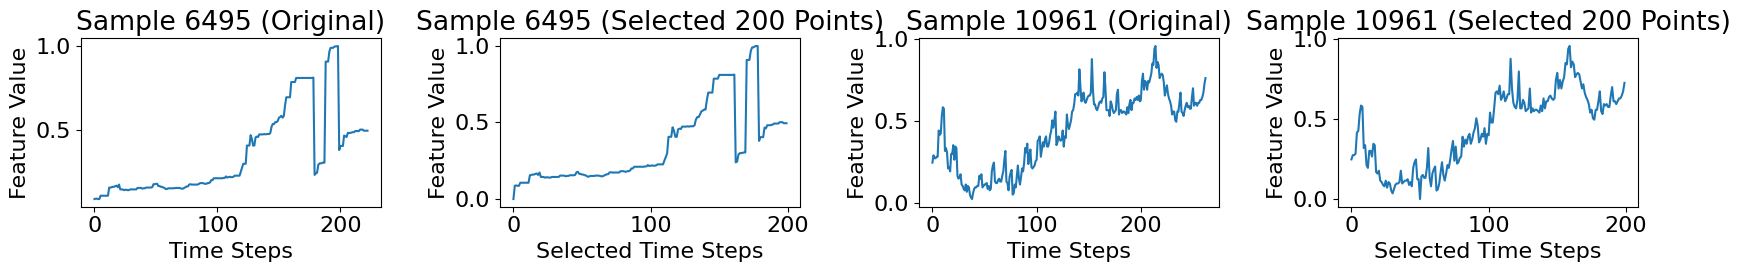

In [20]:
# Plot original and reduced

num_samples_per_row = 2
num_rows = len(indices) // num_samples_per_row

N = 5
desired_count = N * num_samples_per_row

indices = []

while len(indices) < desired_count:
    idx = random.randint(0, len(reduced_data) - 1)
    if valid_periods[idx][1] - valid_periods[idx][0] > 200:
        indices.append(idx)


for row in range(num_rows):
    plt.figure(figsize=(17, 3))
    
    for col in range(num_samples_per_row):
        idx = row * num_samples_per_row + col

        if idx >= len(indices):
            break

        sample_idx = indices[idx]

        # Find the non-zero indices in the time series
        non_zero_indices = np.nonzero(training_data[sample_idx])[0]

        # Trim the time series to remove padding
        trimmed_series = training_data[sample_idx, non_zero_indices]

        # Select random 200 points from the non-padding part
        print(sample_idx, valid_periods[sample_idx])
        
        if (valid_periods[sample_idx][1] - valid_periods[sample_idx][0] <= 200):
            break
        
        selected_indices = random.sample(range(valid_periods[sample_idx][0], valid_periods[sample_idx][1] - 1), 200)
        selected_indices.sort()
        selected_200_points = training_data[sample_idx, selected_indices]

        # Plot original sample
        plt.subplot(1, num_samples_per_row * 2, col * 2 + 1)
        plt.plot(trimmed_series)
        plt.title(f'Sample {sample_idx + 1} (Original)')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        # Plot selected 200 points
        plt.subplot(1, num_samples_per_row * 2, col * 2 + 2)
        plt.plot(selected_200_points)
        plt.title(f'Sample {sample_idx + 1} (Selected 200 Points)')
        plt.xlabel('Selected Time Steps')
        plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()


# KMean

In [86]:
data = reduced_data

# Define the autoencoder
input_dim = len(data[0])  # Number of features
encoding_dim = 128  # Size of the encoded representations

# Encoder
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(256, activation='relu')(input_layer)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder
autoencoder = tf.keras.models.Model(input_layer, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(data, data, epochs=200, batch_size=128, shuffle=True)

# Encoder model
encoder = tf.keras.models.Model(input_layer, encoded)

# Encode the training data
encoded_data = encoder.predict(data)

# Apply clustering on the encoded data
n_clusters = 9  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(encoded_data)


Epoch 1/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0231
Epoch 2/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0076
Epoch 3/200
177/177 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 4/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 5/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 6/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 7/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 8/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 9/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 10/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0039
Epoch 11/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0038
Epoch 12/200
177/177 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 13/200


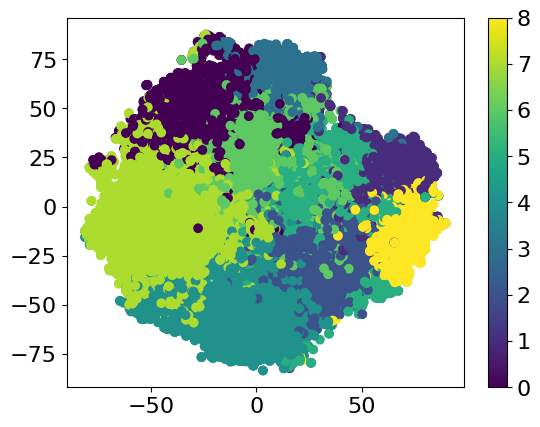

In [82]:
# Visualize the clusters (optional, using t-SNE for dimensionality reduction)
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_data)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.show()


In [83]:
clusters

array([6, 5, 0, ..., 2, 8, 3], dtype=int32)

In [84]:
reduced_data

array([[4.91666667e-01, 5.44444444e-01, 4.63888889e-01, ...,
        7.56481481e-01, 7.44444444e-01, 5.16666667e-01],
       [4.80000000e-01, 5.00000000e-01, 4.20000000e-01, ...,
        7.40000000e-01, 5.36000000e-01, 6.00000000e-01],
       [0.00000000e+00, 2.75798242e-02, 2.92457196e-02, ...,
        9.16705229e-01, 9.55205923e-01, 9.60481259e-01],
       ...,
       [7.62564991e-03, 0.00000000e+00, 5.54592721e-03, ...,
        3.42807626e-01, 3.13344887e-01, 2.88734835e-01],
       [1.44300144e-02, 1.30591631e-01, 1.78932179e-01, ...,
        2.42424242e-01, 2.35930736e-01, 2.09956710e-01],
       [5.91303333e-04, 1.31518589e-03, 5.03801046e-04, ...,
        1.78899752e-01, 1.79833109e-01, 5.87410807e-01]])

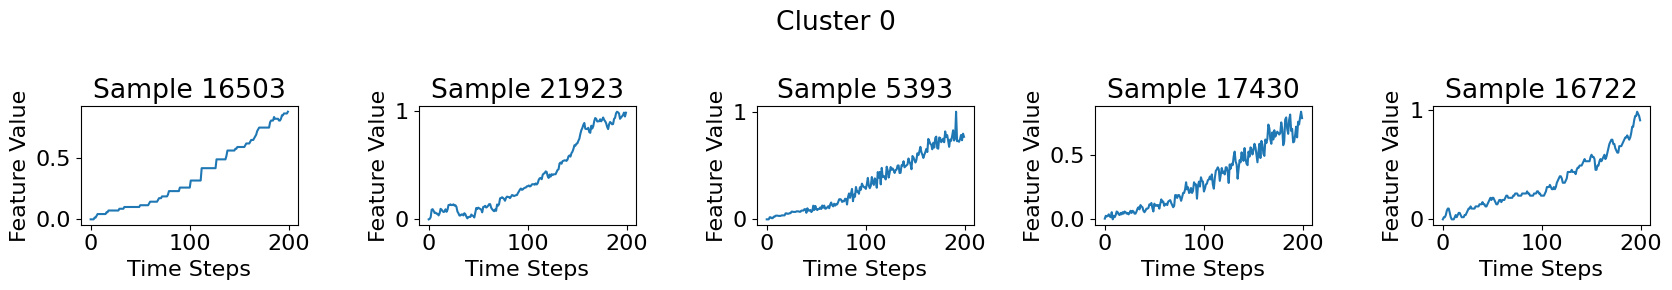

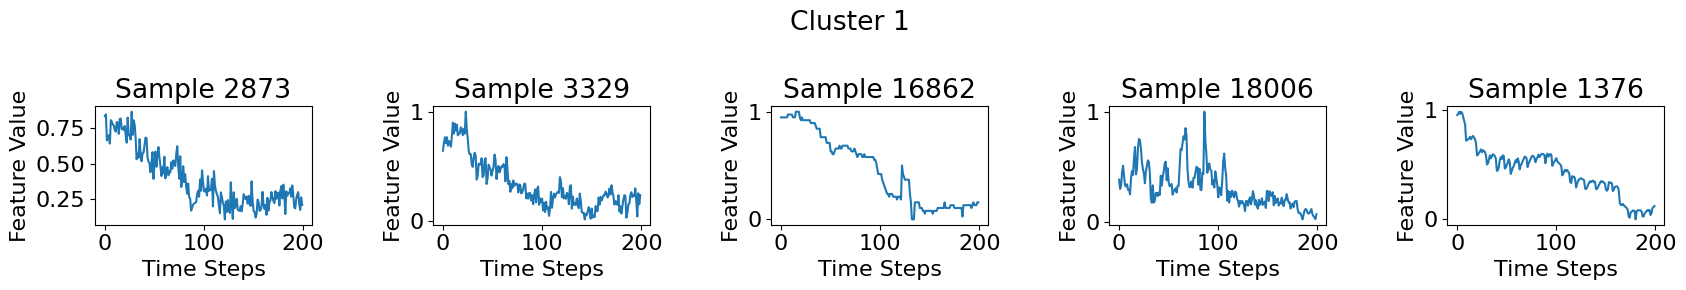

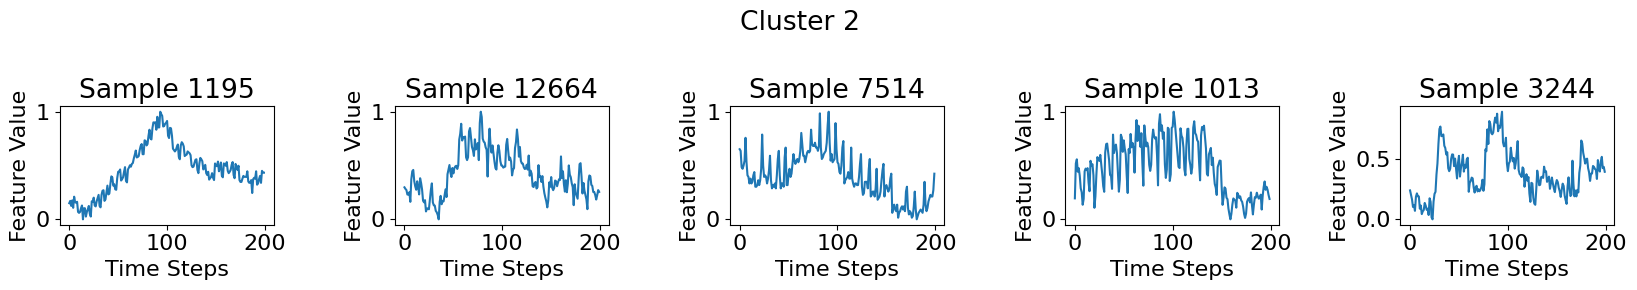

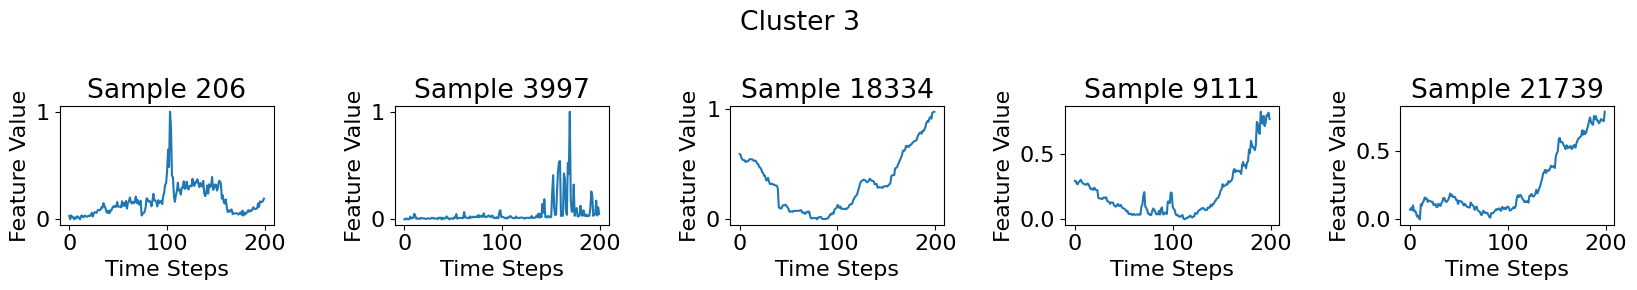

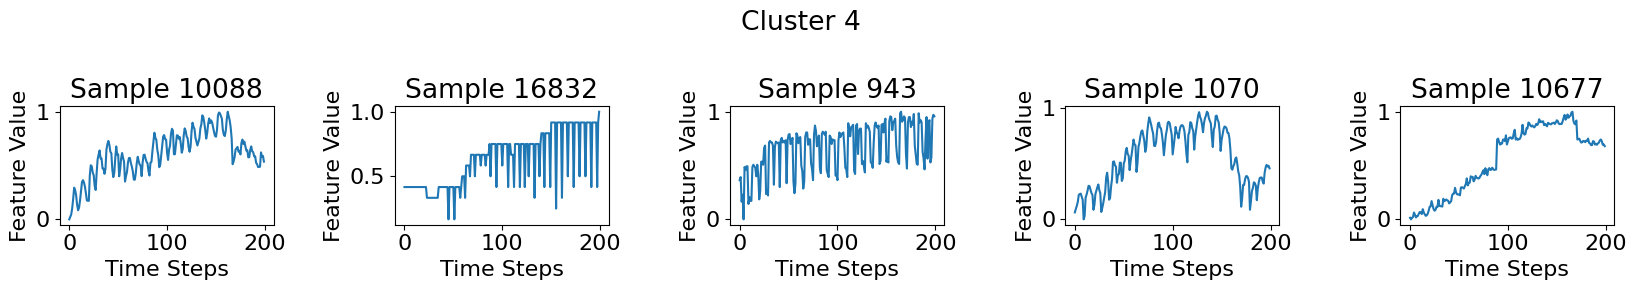

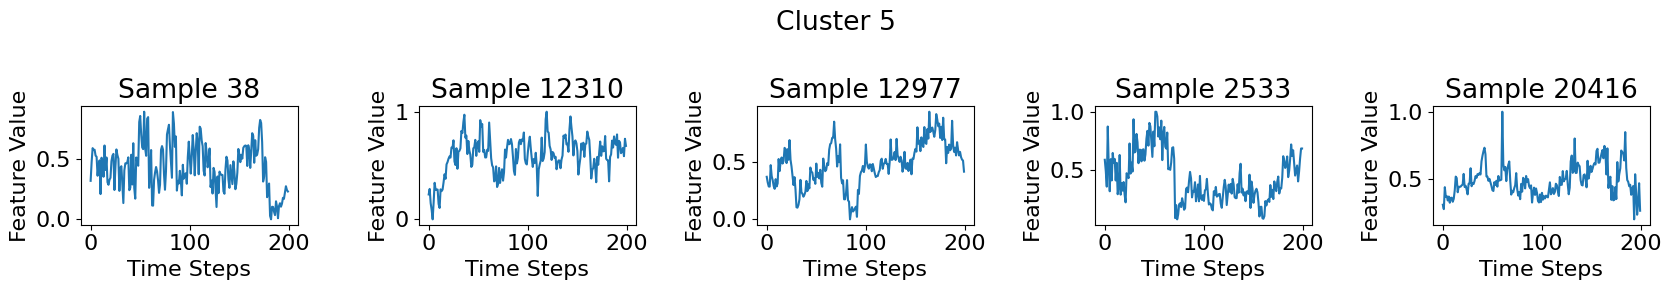

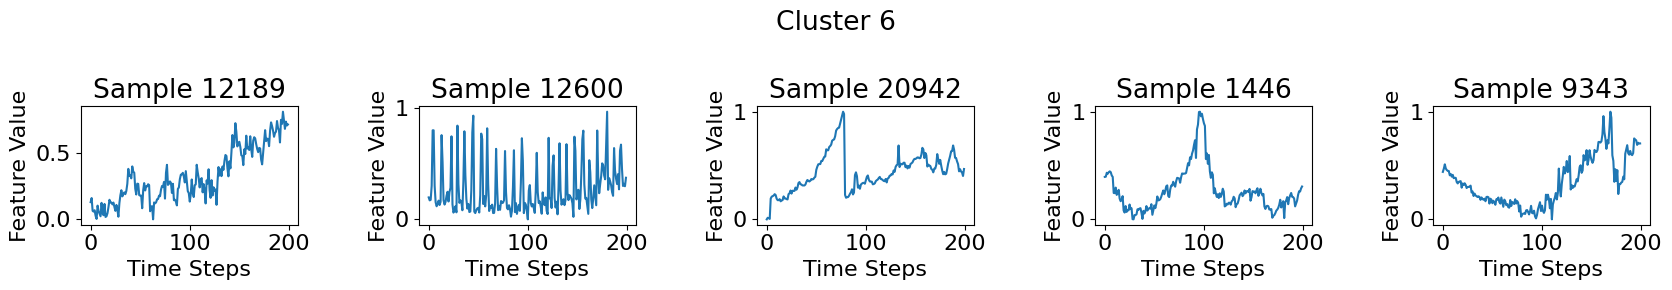

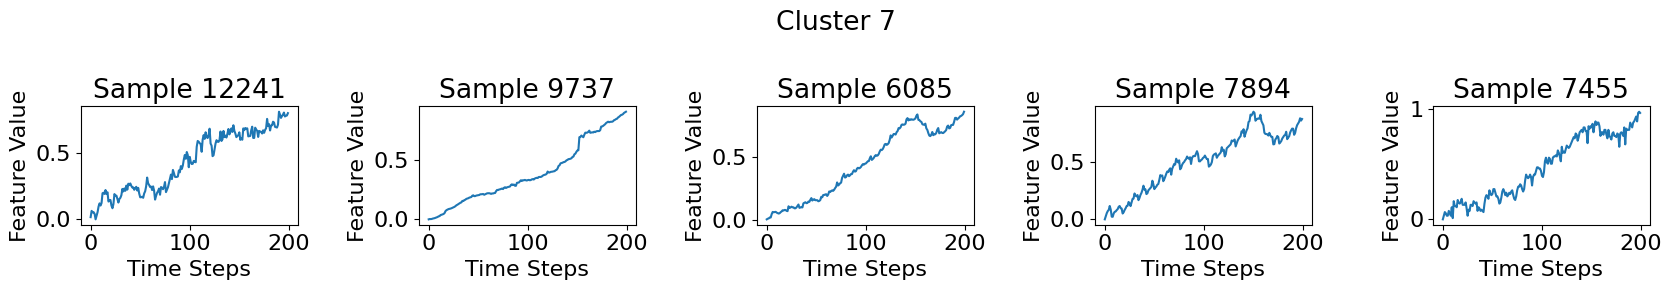

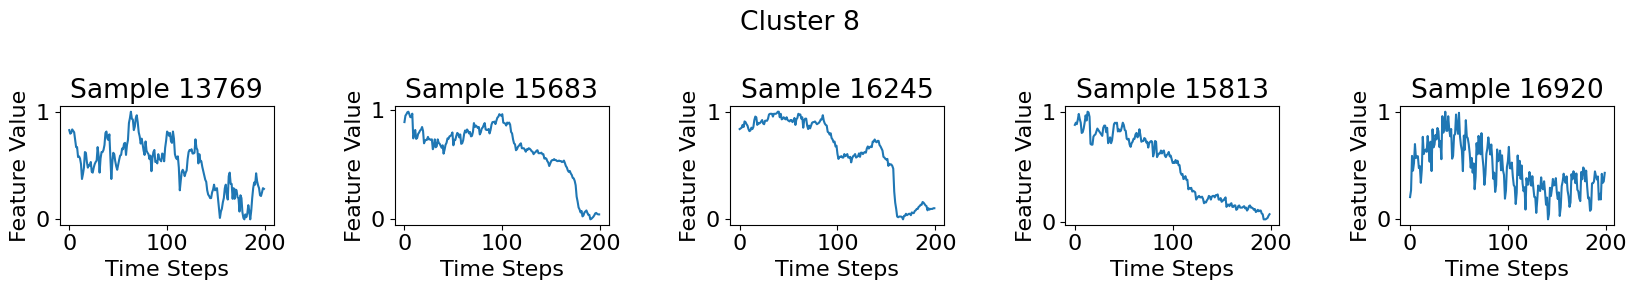

In [85]:
# Define the number of clusters and samples per cluster to plot
num_clusters = 9
num_samples_per_row = 5

# Select N random samples from each cluster
indices = []
for cluster in range(num_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    cluster_samples = random.sample(list(cluster_indices), min(num_samples_per_row, len(cluster_indices)))
    indices.append(cluster_samples)

for row in range(num_clusters):
    plt.figure(figsize=(17, 3))
    plt.suptitle(f'Cluster {row}')

    for col in range(num_samples_per_row):

        if idx >= len(indices):
            break

        sample_idx = indices[row][col]

        plt.subplot(1, num_samples_per_row, col + 1)
        plt.plot(reduced_data[sample_idx])
        plt.title(f'Sample {sample_idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

# pokusaj gptov

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data
data = np.load('/kaggle/input/training/training_data.npy')
valid_periods = np.load('/kaggle/input/training/valid_periods.npy')
categories = np.load('/kaggle/input/training/categories.npy')

# Find the maximum sequence length
max_length = max(valid_periods[:, 1] - valid_periods[:, 0])

# Preprocess data
def preprocess_data(data, valid_periods, max_length):
    processed_data = []
    scaler = StandardScaler()

    for ts, (start, end) in zip(data, valid_periods):
        # Remove padding based on valid periods
        ts = ts[start:end]

        # Standardize data
        ts = scaler.fit_transform(ts.reshape(-1, 1)).flatten()

        # Pad sequences to a common length
        ts = pad_sequences([ts], maxlen=max_length, padding='post').flatten()

        processed_data.append(ts)

    return np.array(processed_data)

processed_data = preprocess_data(data, valid_periods, max_length)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    processed_data, processed_data, test_size=0.2, random_state=42
)

# Define and train your model
class TimeSeriesModel:
    def __init__(self, sequence_length):
        self.model = self.build_model(sequence_length)

    def build_model(self, sequence_length):
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(50, activation='relu', input_shape=(None, 1)),
            tf.keras.layers.Dense(sequence_length)  # Adjust based on the forecasting period
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train(self, X, y, epochs=10, batch_size=32):
        X = np.expand_dims(X, axis=-1)
        y = np.expand_dims(y, axis=-1)
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Initialize and train the model
sequence_length = max_length  # Use the previously defined max_length
model = TimeSeriesModel(sequence_length)
model.train(X_train, y_train)

# Evaluate on the Phase 1 test set
X_val = np.expand_dims(X_val, axis=-1)
y_pred = model.model.predict(X_val)
mse_phase1 = mean_squared_error(y_val, y_pred)  # Use full length for evaluation

print(f'Mean Squared Error on Phase 1 Test Set: {mse_phase1}')

# Save the model for Phase 2 submission
model.model.save('/kaggle/working/saved_model_phase1')
